# Predicting Student Performance
### Creating Models for Training and Testing

Data is the Student Performance data set from the UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Student+Performance

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import mode
from tabulate import tabulate
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

# Models used for Project
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

### All preprocessing done in stu_perf_eda.ipynb

In [4]:
all_stu = pd.read_csv("/Users/connorpatrom/introToDataScience/project/data/encoded_student_per.csv")

### Creating Train/Test Split and k-fold CV

In [5]:
train_df, test_df = train_test_split(all_stu, test_size=0.3, random_state=7)  # splitting data on 80/20 (train/test)

In [6]:
folds = KFold(n_splits=5, shuffle=True)

### Splitting data into Features and Response

In [7]:
# slicing data into features and response for train and test
x_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:,-1].values

x_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:,-1].values

In [8]:
headers = ["Fold", "Accuracy", "Precision", "Recall", "f1", "AUROC"] # headers for metric table

### Creating Baseline Model

In [9]:
re_var = all_stu.iloc[:,-1].values
most = mode(re_var, keepdims = True)
print(f"Mode of the Response Variable: {most[0]}")

Mode of the Response Variable: [1]


In [10]:
header = ["Accuracy", "Precision", "Recall", "f1", "AUROC"] # headers for metric table

baseline_preds = np.ones_like(re_var)  # creating numpy array of most common class 1

accuracy = accuracy_score(re_var, baseline_preds)
precision = precision_score(re_var, baseline_preds)
recall = recall_score(re_var, baseline_preds)
f1 = f1_score(re_var, baseline_preds)
roc_auc = roc_auc_score(re_var, baseline_preds)

results = [[accuracy, precision, recall, f1, roc_auc]]

print(tabulate(results, headers=header, floatfmt=".2f"))

  Accuracy    Precision    Recall    f1    AUROC
----------  -----------  --------  ----  -------
      0.63         0.63      1.00  0.78     0.50


Not very good as expected. Recall makes sense as TP / (TP + FN) = 1, there is 0 FN

## Random Forest Model

#### 5 k-fold Cross Validation using just the Training Data Set

In [11]:
results = []

for fold, (train_idx, val_idx) in enumerate(folds.split(x_train, y_train)):
    clf_rf = RandomForestClassifier(n_estimators=100)
    clf_rf.fit(x_train[train_idx], y_train[train_idx])
    preds = clf_rf.predict(x_train[val_idx])
    actual = y_train[val_idx]

    accuracy = accuracy_score(actual, preds)
    precision = precision_score(actual, preds)
    recall = recall_score(actual, preds)
    f1 = f1_score(actual, preds)
    roc_auc = roc_auc_score(actual, preds)

    results.append([fold+1, accuracy, precision, recall, f1, roc_auc])

print(tabulate(results, headers=headers, floatfmt=".2f"))

  Fold    Accuracy    Precision    Recall    f1    AUROC
------  ----------  -----------  --------  ----  -------
     1        0.92         0.95      0.94  0.94     0.92
     2        0.92         0.96      0.93  0.94     0.92
     3        0.93         0.94      0.96  0.95     0.92
     4        0.91         0.91      0.94  0.93     0.90
     5        0.92         0.95      0.93  0.94     0.91


#### Fitting model to full training set and then predicting never seen test data set

In [16]:
header = ["Accuracy", "Precision", "Recall", "f1", "AUROC"] # headers for metric table
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=1)
clf_rf.fit(x_train, y_train)
predict = clf_rf.predict(x_test)

accuracy = accuracy_score(y_test, predict)
precision = precision_score(y_test, predict)
recall = recall_score(y_test, predict)
f1 = f1_score(y_test, predict)
roc_auc = roc_auc_score(y_test, predict)

results = [[accuracy, precision, recall, f1, roc_auc]]

print(tabulate(results, headers=header, floatfmt=".2f"))

  Accuracy    Precision    Recall    f1    AUROC
----------  -----------  --------  ----  -------
      0.86         0.86      0.92  0.89     0.84


## XGBoost Model

#### 5 k-fold Cross Validation using just the Training Data Set

In [22]:
results = []

for fold, (train_idx, val_idx) in enumerate(folds.split(x_train, y_train)):
    clf_xg = xgb.XGBClassifier(colsample_bytree=0.5, eta=0.01, max_depth=3, n_estimators=100, subsample=0.8)
    clf_xg.fit(x_train[train_idx], y_train[train_idx])
    preds = clf_xg.predict(x_train[val_idx])
    actual = y_train[val_idx]

    accuracy = accuracy_score(actual, preds)
    precision = precision_score(actual, preds)
    recall = recall_score(actual, preds)
    f1 = f1_score(actual, preds)
    roc_auc = roc_auc_score(actual, preds)

    results.append([fold+1, accuracy, precision, recall, f1, roc_auc])

print(tabulate(results, headers=headers, floatfmt=".2f"))

  Fold    Accuracy    Precision    Recall    f1    AUROC
------  ----------  -----------  --------  ----  -------
     1        0.90         0.92      0.91  0.92     0.89
     2        0.94         0.94      0.97  0.95     0.92
     3        0.96         0.98      0.96  0.97     0.96
     4        0.92         0.92      0.95  0.93     0.91
     5        0.95         0.96      0.97  0.96     0.95


#### Fitting model to full training set and then predicting never seen test data set

In [28]:
header = ["Accuracy", "Precision", "Recall", "f1", "AUROC"] # headers for metric table
clf_xg = xgb.XGBClassifier(colsample_bytree=0.5, eta=0.01, max_depth=3, n_estimators=100, subsample=0.8)
clf_xg.fit(x_train, y_train)
pred = clf_xg.predict(x_test)

accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)
f1 = f1_score(y_test, pred)
roc_auc = roc_auc_score(y_test, pred)

results = [[accuracy, precision, recall, f1, roc_auc]]

print(tabulate(results, headers=header, floatfmt=".2f"))

  Accuracy    Precision    Recall    f1    AUROC
----------  -----------  --------  ----  -------
      0.90         0.93      0.90  0.92     0.90


#### AUROC Visulizations

In [29]:
prob_rf = clf_rf.predict_proba(x_test)
preds_rf = prob_rf[:, 1]

prob_xg = clf_xg.predict_proba(x_test)
preds_xg = prob_xg[:, 1]

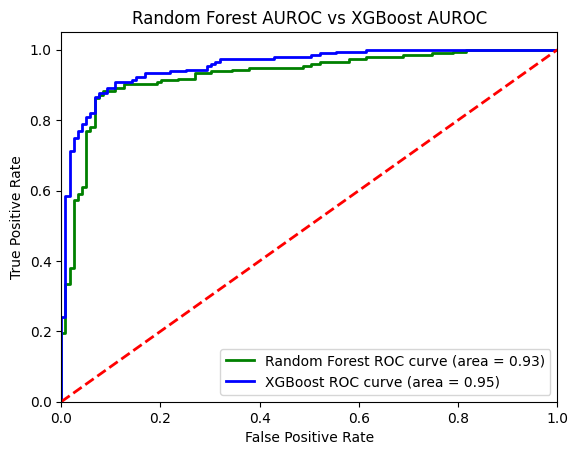

In [30]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, preds_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xg, tpr_xg, thresholds_xg = roc_curve(y_test, preds_xg)
roc_auc_xg = auc(fpr_xg, tpr_xg)

plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label='Random Forest ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot(fpr_xg, tpr_xg, color='blue', lw=2, label='XGBoost ROC curve (area = %0.2f)' % roc_auc_xg)

plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest AUROC vs XGBoost AUROC')
plt.legend(loc="lower right")
plt.show()